In [9]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
print(tf.__version__)

2.1.0


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Language" data-toc-modified-id="Language-1">Language</a></span><ul class="toc-item"><li><span><a href="#Character-and-Word-Embeddings" data-toc-modified-id="Character-and-Word-Embeddings-1.1">Character and Word Embeddings</a></span><ul class="toc-item"><li><span><a href="#Methods-of-Word-Embedding" data-toc-modified-id="Methods-of-Word-Embedding-1.1.1">Methods of Word Embedding</a></span><ul class="toc-item"><li><span><a href="#SVD-Based-Word-Embeddings" data-toc-modified-id="SVD-Based-Word-Embeddings-1.1.1.1">SVD Based Word Embeddings</a></span></li><li><span><a href="#Word2Vec" data-toc-modified-id="Word2Vec-1.1.1.2">Word2Vec</a></span></li><li><span><a href="#Glove" data-toc-modified-id="Glove-1.1.1.3">Glove</a></span></li></ul></li></ul></li><li><span><a href="#Language-Models" data-toc-modified-id="Language-Models-1.2">Language Models</a></span><ul class="toc-item"><li><span><a href="#Count-Based-N-Gram-Models" data-toc-modified-id="Count-Based-N-Gram-Models-1.2.1">Count Based N Gram Models</a></span></li><li><span><a href="#Neural-Language-Models" data-toc-modified-id="Neural-Language-Models-1.2.2">Neural Language Models</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3">Evaluation</a></span></li></ul></li><li><span><a href="#Sentence-Embeddings" data-toc-modified-id="Sentence-Embeddings-1.3">Sentence Embeddings</a></span></li></ul></li><li><span><a href="#Code" data-toc-modified-id="Code-2">Code</a></span><ul class="toc-item"><li><span><a href="#Word-Embeddings-(Tutorial)" data-toc-modified-id="Word-Embeddings-(Tutorial)-2.1">Word Embeddings (<a href="https://www.tensorflow.org/tutorials/text/word_embeddings" target="_blank">Tutorial</a>)</a></span><ul class="toc-item"><li><span><a href="#Learning-Embeddings" data-toc-modified-id="Learning-Embeddings-2.1.1">Learning Embeddings</a></span></li></ul></li><li><span><a href="#Text-Generation-w-RNN-(Tutorial)" data-toc-modified-id="Text-Generation-w-RNN-(Tutorial)-2.2">Text Generation w RNN (<a href="https://www.tensorflow.org/tutorials/text/text_generation" target="_blank">Tutorial</a>)</a></span></li></ul></li></ul></div>

# Language

## Character and Word Embeddings

__Character embeddings__ assign a vector for each character in a written language.

__Word Embeddings__ assign a vector for each word. use dense vectors instead of One Hot Encoding (100-1000 dimension vector) Useful if vector assignment captures semantic meaning of words.

__Distributional Hypothesis__ Words that appear in similar contexts have similar meaning. (Judege a word by the company it keeps) Every method that embeds words into a dense representation uses this assumption.

### Methods of Word Embedding

#### SVD Based Word Embeddings
Use the contextual neighbors of a word to build a matrix representation of the language.(requires lots of data) Context can be a window of variable size (two neighbors or full document)

 Forms a matrix $X$ w/ unique words as rows and unique contexts as columns. Each entry is the probability or counts (sometimes smoothed) of a word being in a given context.
 
 Next $X$ is decomposed with SVD. 
 $$X = U \cdot S \cdot V^T$$
 
Decide the number of rows in $U$ and $V^T$, Each row of $U\cdot S$ is a word embedding.

#### Word2Vec

creates a dense vector representation by predicting context igven word (skip-gram) or word given context (CBOW). Uses a two-layer neural network to learn the representation (two dense laters w/ hierarchical softmax)

CBOW (word given context)
- input is OHE word vector for each word in context
- Embedding (Layer 1) is $NUM_WORDS\times REPR_LENGTH$ representing the word embeddings
- embedding (layer 2) is $REPR_LENGTH \times NUM_WORDS$ context embeddings

Skip Gram (context given word) 

Does a better job with infrequent words,
slightly worse with small data sets, slightly
better with large data sets
- input is OHE vector with word

Optimization methods: 
- Hierarchical softmax. (quicker computation for a softmax output with huge numbe of dimensions)
- Negative sampling - only update a subset of all words for each sample (Predict is this in context YES/NO)
- Sample inversely based on word frequency. (so rarer words can be processed more often)

In [4]:
#CBOW WORD2VEC
WINDOW_SIZE = 5
LANGUAGE_SIZE = 1000
EMB_DIMENSIONS = 200

#Matrix of OHE Vectors
inputs = tf.keras.Input(shape=(LANGUAGE_SIZE, WINDOW_SIZE*2), batch_size=32)
#WORD EMBEDDINGS (Lang_Size, emb_size)
dense1 = tf.keras.layers.Dense(EMB_DIMENSIONS, activation=None)(inputs)
#CONTEXT EMBEDDINGS (emb_size, Lang_Size)
outputs = tf.keras.layers.Dense(LANGUAGE_SIZE, activation='softmax')(dense1)

Word2Vec = tf.keras.Model(inputs=inputs, outputs=outputs) 

#### Glove

Purpose is to combine statistical benefits of global matrix factorization methods with analogy benefits of context window based methods.

## Language Models

Predict the Nth word in a N word sequence given the first N-1 words. Estimate the conditional probabilities $P(W_N|W_{N-1},...W_1)$

### Count Based N Gram Models

Assign probabilities based on counts of word cooccurences in a training dataset. Suffers from issues when a combo of words has not been seen before (count based approach gives this a zero probability since it hasnt been seen before)

__Smoothing__ Distribute the probability masss function evenly across all input so there are no zero probability combinationsa of words.

__Backoff__ Use N-2 sequence of last words if N-1 sequence has never been seen before. If N-2 has never been seen before, continue recursively.

### Neural Language Models

Start with an embedding layer that seeks to encode each of the first N-1 words. Concatenate the word vectors, and process through multiple intermediate layers, softmax classifier head to predict PMF of Nth word. 

Benefits: count-based methods employed a look-up table $\rightarrow$ very large storage size. Neural models are significantly smaller, and can learn nonlinear relationships

__Standard Neural Network (Dense layers)__ is akin to N-grams since there is a required, fixed-size input. Must make the context window a parameter in architecture creation.

__Recurrent Neural Networks__ process each of the N-1 words, retaining a hidden state vector at each time step. The Final timestep at N-1 is processed with a softmax head to predict the output word

### Evaluation

Generally use CrossEntropy to compare the difference between learned PMF representation and the training dataset PMF. Estimate the true distribution with the training data.

__Cross Entropy__

$$H(p,q)=-\sum_x \frac{1}{N}log_2(q(x))$$


__Perplexity__ $$Perplexity = 2^{H(training data, q}$$

## Sentence Embeddings

__Basic Strategy__
- Input data, words mapped to vectors w w2v model
- Encoder, Transformer
- Output features viewed as input embedding
- Decoder for semisupervised task (predict next word, masked word)
- Remove decoder, use encoder for embeddings
- Fine tune encoder on new task




# Code

## Word Embeddings ([Tutorial](https://www.tensorflow.org/tutorials/text/word_embeddings))

In [20]:
LANGUAGE_SIZE = 1000
EMBED_SIZE = 5

#Takes a tensor of integers as input (integer indices of words)
emb_layer = layers.Embedding(LANGUAGE_SIZE, EMBED_SIZE)
#output has one more axis dim than the input, emb_dim is aligned to final axis
emb_layer(tf.constant([1,25,4])).numpy()

array([[ 0.02164057,  0.03744939, -0.0439635 ,  0.02033074, -0.04208026],
       [-0.0128045 , -0.00542085,  0.04022874,  0.01654496,  0.02081278],
       [ 0.01869465, -0.0223659 ,  0.00361943, -0.02965592,  0.02137938]],
      dtype=float32)

### Learning Embeddings

In [11]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

In [13]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))

In [25]:
train_batch, train_labels = next(iter(train_batches))
print(train_batch.numpy())
print(train_labels.numpy())

[[  62    9 2639 ...    0    0    0]
 [ 324   12  284 ...    0    0    0]
 [ 156   12   77 ...    0    0    0]
 ...
 [ 133   32   60 ...    0    0    0]
 [  62   27 1915 ...    0    0    0]
 [7971  264 3442 ... 2296  106 7996]]
[1 1 0 0 0 0 0 0 0 0]


In [18]:
encoder = info.features['text'].encoder
encoder.subwords[:5]

['the_', ', ', '. ', 'a_', 'and_']

In [23]:
EMBED_SIZE = 50

CBOW = tf.keras.Sequential([
    layers.Embedding(encoder.vocab_size, EMBED_SIZE),
    layers.GlobalAvgPool1D(), #returns a fixed-length output (avgs all wordvecs)
    layers.Dense(EMBED_SIZE, activation='relu'),
    layers.Dense(1)
])

CBOW.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          409250    
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 411,851
Trainable params: 411,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
CBOW.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = CBOW.fit(train_batches, 
                   epochs=10,
                  validation_data=test_batches,
                  validation_steps=50)

Epoch 1/10
2500/2500 [==============================] - 26s 11ms/step - loss: 0.4440 - accuracy: 0.7516 - val_loss: 0.3267 - val_accuracy: 0.8380
Epoch 2/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.2502 - accuracy: 0.8994 - val_loss: 0.3668 - val_accuracy: 0.8240
Epoch 3/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.2050 - accuracy: 0.9211 - val_loss: 0.3438 - val_accuracy: 0.8660
Epoch 4/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1750 - accuracy: 0.9324 - val_loss: 0.3726 - val_accuracy: 0.8720
Epoch 5/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1580 - accuracy: 0.9399 - val_loss: 0.3603 - val_accuracy: 0.8640
Epoch 6/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1402 - accuracy: 0.9469 - val_loss: 0.4017 - val_accuracy: 0.8720
Epoch 7/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1243 - accuracy: 0.9548 - val_loss: 0.5332 - val_a

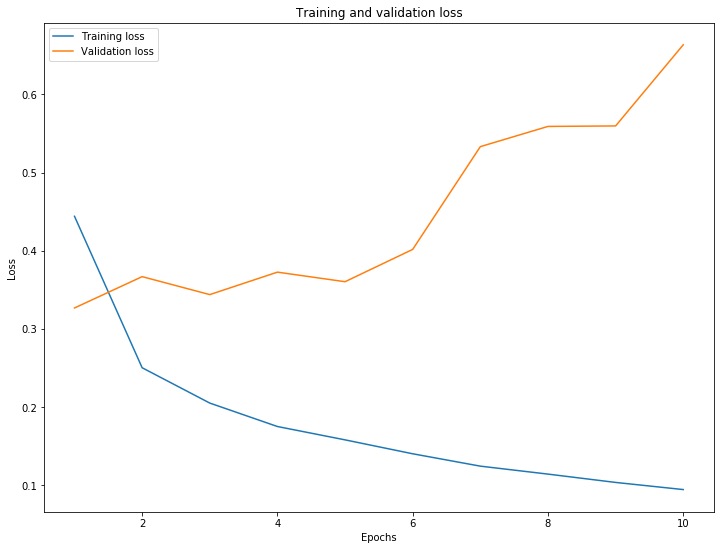

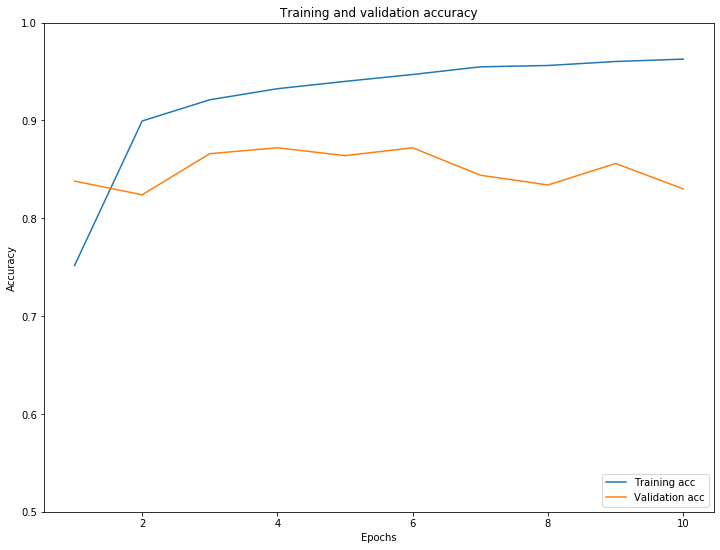

In [27]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [30]:
emb = CBOW.layers[0].get_weights()[0]
emb

array([[-0.01638222, -0.00261636, -0.00324426, ...,  0.01645428,
        -0.00083825, -0.00332281],
       [ 0.07070546, -0.06580278,  0.07252844, ..., -0.062823  ,
         0.09458104, -0.05641985],
       [ 0.06520953, -0.06563348,  0.06022033, ..., -0.07197564,
         0.09575895, -0.0450202 ],
       ...,
       [-0.03457276, -0.00926349,  0.04601792, ...,  0.01853222,
         0.00895938,  0.03236464],
       [ 0.01728059, -0.04150518,  0.00160787, ...,  0.02900282,
        -0.02033439, -0.01486714],
       [-0.03211838,  0.04820878,  0.02725622, ...,  0.00728808,
         0.01759252, -0.04223058]], dtype=float32)

In [35]:
import io

path = "F:\\Models\\Language_Models\\Embeddings\\"
out_v = io.open(path+'vecs.tsv', 'w', encoding='utf-8')
out_m = io.open(path+'meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords): #list of words
    vec = emb[num+1] # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n") #floats seperated by \t
out_v.close()
out_m.close()

## Text Generation w RNN ([Tutorial](https://www.tensorflow.org/tutorials/text/text_generation))

In [57]:
import numpy as np
import os

In [36]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

1122304/1115394 [==============================] - 0s 0us/step
Length of text: 1115394 characters


In [39]:
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [42]:
vocab = sorted(set(text))
print(vocab)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [46]:
char2idx = {u:i for i,u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[char] for char in text])

In [49]:
SEQ_LENGTH = 100
examples_per_epoch = len(text)//(SEQ_LENGTH+1)

sequences = tf.data.Dataset.from_tensor_slices(text_as_int).batch(SEQ_LENGTH+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [54]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [55]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [56]:
EMB_DIM = 50
RNN_UNITS = 1024
VOCAB_SIZE = len(vocab)

model = tf.keras.Sequential([
    layers.Embedding( VOCAB_SIZE, EMB_DIM, 
                     batch_input_shape=[BATCH_SIZE, None]),
    layers.GRU(RNN_UNITS, 
              return_sequences=True,
               stateful=True),
    layers.Dense(VOCAB_SIZE)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (64, None, 50)            3250      
_________________________________________________________________
gru_2 (GRU)                  (64, None, 1024)          3305472   
_________________________________________________________________
dense_4 (Dense)              (64, None, 65)            66625     
Total params: 3,375,347
Trainable params: 3,375,347
Non-trainable params: 0
_________________________________________________________________


In [62]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam',
            loss = loss)

In [68]:
base_path = "F:\\Models\\Language_Models\\RNN_Language_Generation\\"
path = os.path.join(base_path, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath = path,
save_weights_only = True)

In [64]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 172 steps
Epoch 1/10
172/172 [==============================] - 11s 62ms/step - loss: 2.8199
Epoch 2/10
172/172 [==============================] - 8s 48ms/step - loss: 2.1167
Epoch 3/10
172/172 [==============================] - 8s 48ms/step - loss: 1.8556
Epoch 4/10
172/172 [==============================] - 8s 49ms/step - loss: 1.6759
Epoch 5/10
172/172 [==============================] - 8s 49ms/step - loss: 1.5573
Epoch 6/10
172/172 [==============================] - 9s 50ms/step - loss: 1.4778
Epoch 7/10
172/172 [==============================] - 8s 49ms/step - loss: 1.4170: 2s - loss: 1.41
Epoch 8/10
172/172 [==============================] - 9s 50ms/step - loss: 1.3699
Epoch 9/10
172/172 [==============================] - 9s 50ms/step - loss: 1.3284
Epoch 10/10
172/172 [==============================] - 9s 50ms/step - loss: 1.2904


In [69]:
BATCH_SIZE = 1

model = tf.keras.Sequential([
    layers.Embedding( VOCAB_SIZE, EMB_DIM, 
                     batch_input_shape=[BATCH_SIZE, None]),
    layers.GRU(RNN_UNITS, 
              return_sequences=True,
               stateful=True),
    layers.Dense(VOCAB_SIZE)
])
model.load_weights(tf.train.latest_checkpoint(base_path))
model.build(tf.TensorShape([1,None])) #one char at a time

In [ ]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))